# NNet class in Pytorch

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [1]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

Complete the following definition of class `NNet` by completing its `train` and `use` functions.  These functions must be completed the *PyTorch* way, which is **not** identical to how you completed the network in A2 (though the same principles apply)!

In [2]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh', gpu=False):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
        self.gpu = gpu
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        self.error_trace = []
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
            
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
            
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        #   Do forward pass to calculate output Y.
        #   Calculate mean squared error loss, mse.
        #   Calculate gradient of mse with respect to all weights by calling mse.backward().
        #   Take weight update step, then zero the gradient values.
        #   Unstandardize the mse error and save in self.error_trace
        #   Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        for epoch in range(n_epochs):
            Y = self.forward(X)
            mse_s = mse_func(T, Y)
            mse_s.backward()
            optimizer.step()
            optimizer.zero_grad()
            Y_rescale = Y * self.Tstds + self.Tmeans
            T_rescale = T * self.Tstds + self.Tmeans
            RMSE_uns = torch.sqrt(mse_func(T_rescale, Y_rescale))
            self.error_trace.append(RMSE_uns)
            if verbose and ((epoch+1 is n_epochs) or ((epoch+1) % (n_epochs // 10) == 0)):
                print(f'Epoch {epoch + 1}: RMSE {RMSE_uns:.3f}')
    
    def use(self, X):
        # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
            
        # Standardize Xabs
        Xs = (X - self.Xmeans) / self.Xstds
        
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
        Ys = self.forward(Xs)
        Y = Ys * self.Tstds + self.Tmeans
        if self.gpu:
            return Y.cpu().detach().numpy()
        # Return output Y after detaching from computation graph and converting to numpy
        return Y.detach().numpy()


## Example

In [3]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y = net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')

Epoch 5: RMSE 11.155
Epoch 10: RMSE 6.062
Epoch 15: RMSE 5.169
Epoch 20: RMSE 2.103
Epoch 25: RMSE 2.317
Epoch 30: RMSE 2.636
Epoch 35: RMSE 1.463
Epoch 40: RMSE 1.137
Epoch 45: RMSE 1.170
Epoch 50: RMSE 0.922
RMSE 0.867


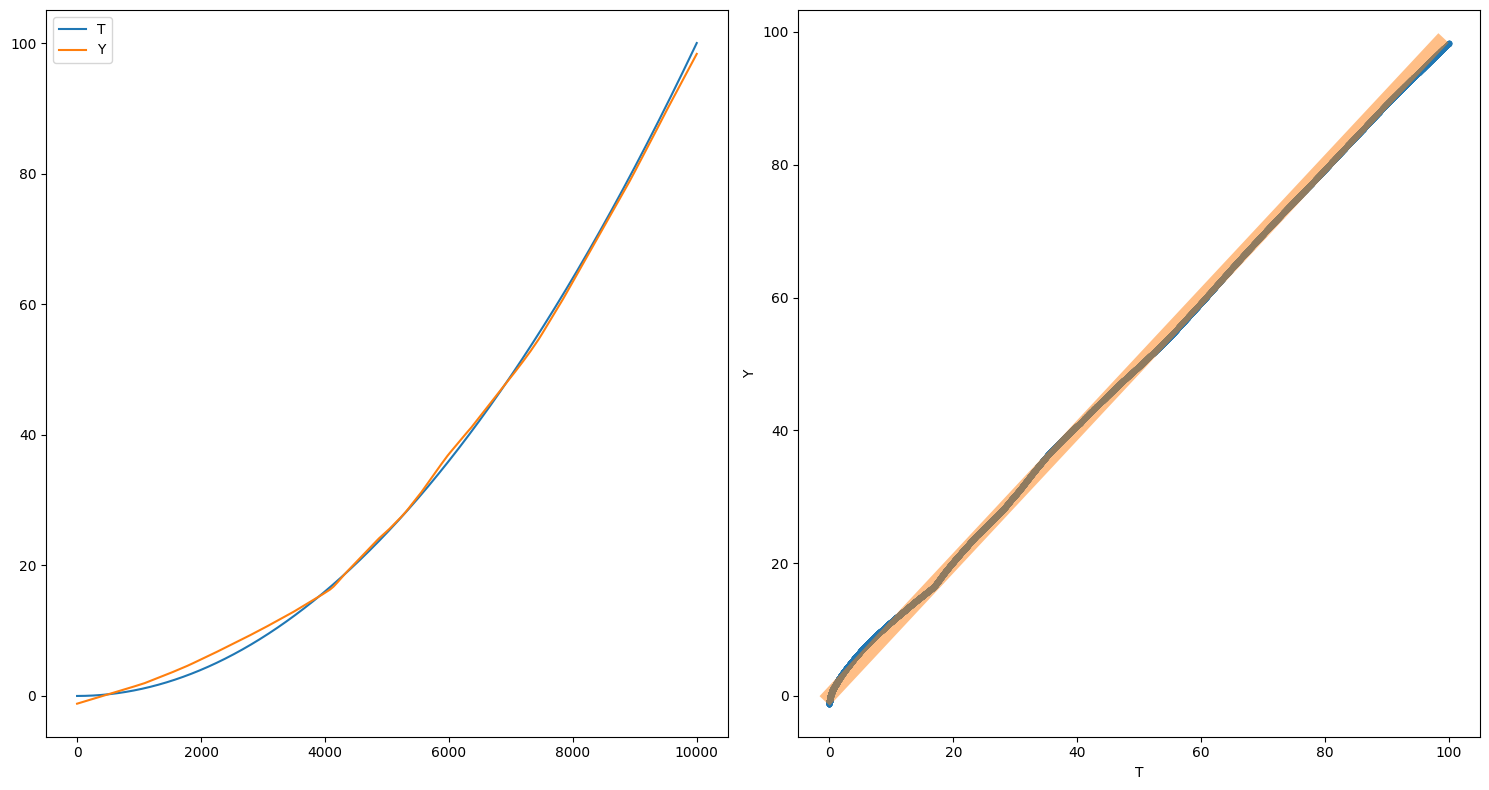

In [4]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

## Implementation

This is complete code for `generate_k_fold_cross_validation_sets`.

In [5]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [6]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]),
 array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [7]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  

For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. 

Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  

Append a list of the architecture and these three mean RMSEs to a list of results and return the list as a pandas DataFrame described below when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [8]:
def to_gpu_tensor(np_arr):
    return (torch.from_numpy(np_arr).float()).to('cuda')
    
def rmse(Y, T):
    if isinstance(T, torch.Tensor):
        return np.sqrt(np.mean((T.cpu().detach().numpy() - Y)**2))
    return np.sqrt(np.mean((T - Y)**2))
    
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func, gpu = False):
    arch_list = []
    for n_hidden in list_of_n_hiddens:
        folds = []
        for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest in \
                generate_k_fold_cross_validation_sets(X, T, n_folds):
            n_inputs = Xtrain.shape[1]
            n_outputs = Ttrain.shape[1]
            nnet = NNet(n_inputs, n_hidden, n_outputs, act_func, gpu)
            if gpu:
                print('Moving data and model to GPU')
                Xtrain = to_gpu_tensor(Xtrain)
                Ttrain = to_gpu_tensor(Ttrain)
                Xval = to_gpu_tensor(Xval)
                Tval = to_gpu_tensor(Tval)
                Xtest = to_gpu_tensor(Xtest)
                Ttest = to_gpu_tensor(Ttest)
                nnet.to('cuda')  
            nnet.train(Xtrain, Ttrain, n_epochs, learning_rate)
            Ytrain = nnet.use(Xtrain)
            Yval = nnet.use(Xval)
            Ytest = nnet.use(Xtest)
            trainRMSE = rmse(Ytrain, Ttrain)
            valRMSE = rmse(Yval, Tval)
            testRMSE = rmse(Ytest, Ttest)
            folds.append([trainRMSE, valRMSE, testRMSE])  
        RMSE_means = np.mean(folds, axis=0)
        architecture = [n_hidden, RMSE_means[0], RMSE_means[1], RMSE_means[2] ]
        arch_list.append(architecture)
        
    nn_df = pandas.DataFrame(arch_list)
    nn_df.columns = ['Arch', 'RMSE Train', 'RMSE Val', 'RMSE Test']
    return nn_df

## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) and read it as shown below.

In [9]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))

Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described sufficiently.  If you struggle with judging this yourself, you can consider 10 sentences or more of discussion to be sufficient, but 9 perceptive sentences are better than 10 or more sentences of non-analytical fluff.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [10]:
X = airfoil.to_numpy()[:, 0:6]
T = np.vstack((airfoil.to_numpy()[:, -1]))
X.shape, T.shape

((1503, 6), (1503, 1))

In [11]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [50], [100], [200], [1, 1],
                                      [10, 10], [25, 25], [50, 75], [50, 100], [75, 75], 
                                      [100, 100], [200, 200], [1, 1, 1], [25, 25, 25], 
                                      [150, 150, 150], [25, 50, 75], [50, 100, 200]],
                                      2000, 0.001, 'tanh')

cpu_elapsed = (time.time() - start) / 60/ 60
print(f'Took {cpu_elapsed:.2f} hours')
results

Epoch 200: RMSE 5.319
Epoch 400: RMSE 3.614
Epoch 600: RMSE 2.548
Epoch 800: RMSE 1.894
Epoch 1000: RMSE 1.484
Epoch 1200: RMSE 1.188
Epoch 1400: RMSE 0.946
Epoch 1600: RMSE 0.739
Epoch 1800: RMSE 0.564
Epoch 2000: RMSE 0.417
Epoch 200: RMSE 3.909
Epoch 400: RMSE 2.215
Epoch 600: RMSE 1.468
Epoch 800: RMSE 1.105
Epoch 1000: RMSE 0.846
Epoch 1200: RMSE 0.627
Epoch 1400: RMSE 0.445
Epoch 1600: RMSE 0.301
Epoch 1800: RMSE 0.194
Epoch 2000: RMSE 0.118
Epoch 200: RMSE 5.030
Epoch 400: RMSE 3.363
Epoch 600: RMSE 2.367
Epoch 800: RMSE 1.764
Epoch 1000: RMSE 1.376
Epoch 1200: RMSE 1.100
Epoch 1400: RMSE 0.882
Epoch 1600: RMSE 0.698
Epoch 1800: RMSE 0.539
Epoch 2000: RMSE 0.404
Epoch 200: RMSE 5.995
Epoch 400: RMSE 4.310
Epoch 600: RMSE 3.338
Epoch 800: RMSE 2.683
Epoch 1000: RMSE 2.193
Epoch 1200: RMSE 1.808
Epoch 1400: RMSE 1.489
Epoch 1600: RMSE 1.212
Epoch 1800: RMSE 0.968
Epoch 2000: RMSE 0.754
Epoch 200: RMSE 5.935
Epoch 400: RMSE 3.864
Epoch 600: RMSE 2.645
Epoch 800: RMSE 1.991
Epoch 10

,Arch,RMSE Train,RMSE Val,RMSE Test
0,[],0.568157,0.573151,0.566640
1,[1],1.380731,1.404483,1.373960
2,[5],0.424313,0.450774,0.444901
3,[50],0.151824,0.175694,0.173899
4,[100],0.122789,0.147900,0.146795
5,[200],0.097526,0.123332,0.124153
6,"[1, 1]",1.569201,1.578980,1.571174
7,"[10, 10]",0.159835,0.183246,0.180680
8,"[25, 25]",0.086438,0.099538,0.099723
9,"[50, 75]",0.048339,0.064195,0.061569


Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [12]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.figure(figsize=(12, 6))
    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.xlabel('Architecture')
    plt.ylabel('RMSE')
    plt.title("RMSE VS. Architecture - 2,000 Epochs: Airfoil Data using PyTorch Neural Network")
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

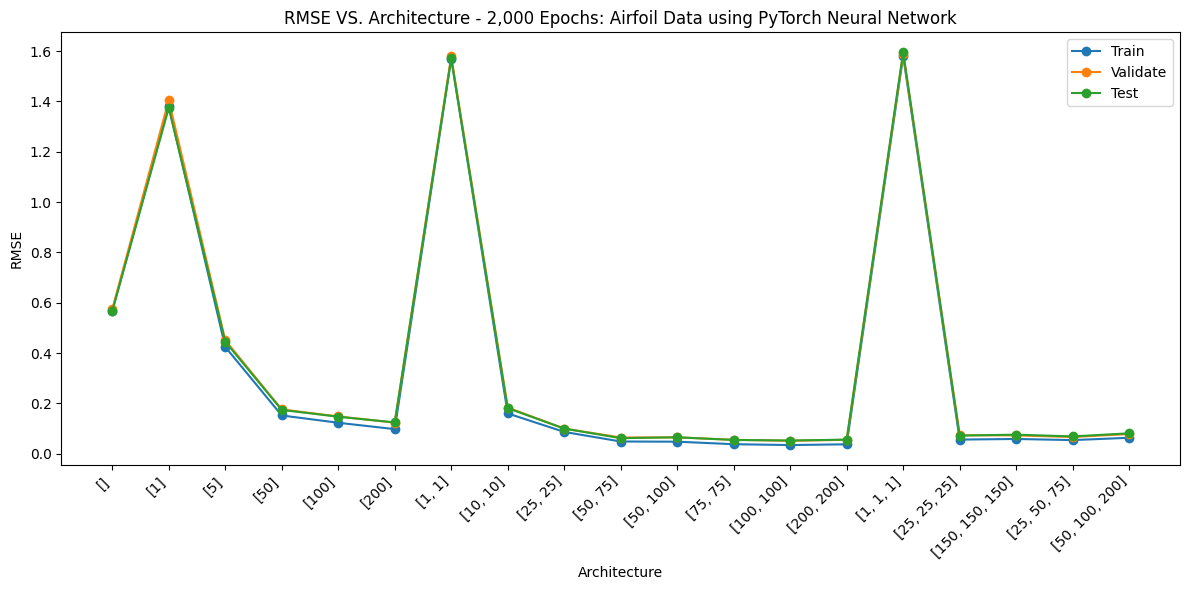

In [13]:
plot_results(results)

In [14]:
results

,Arch,RMSE Train,RMSE Val,RMSE Test
0,[],0.568157,0.573151,0.566640
1,[1],1.380731,1.404483,1.373960
2,[5],0.424313,0.450774,0.444901
3,[50],0.151824,0.175694,0.173899
4,[100],0.122789,0.147900,0.146795
5,[200],0.097526,0.123332,0.124153
6,"[1, 1]",1.569201,1.578980,1.571174
7,"[10, 10]",0.159835,0.183246,0.180680
8,"[25, 25]",0.086438,0.099538,0.099723
9,"[50, 75]",0.048339,0.064195,0.061569


### Description of Results

1. The model seems to perform best with a larger value of hidden units and two hidden layers. 
   
      * When we only use one hidden layer, we start to see RMSE values below 0.2 when there are 50 or more hidden layers. From here, the improvement of RMSE given by the increased architecture complexity starts to gradually plateau as the number of hidden units increases while using one hidden layer. If we increase the number of hidden units from 200, we will likely continue to see diminished improvements of RMSE; and at some point, the model will start to overfit the data.
      * Additionally, having two layers of hidden units seems to perform the best when the number of hidden units for each layer is 10 or more. Again, from this point we see diminishing improvements in RMSE value up to 200 units per layer. We will likely continue to see diminished returns as we increase the number of units. Also, the model will likely start to overfit the data as we increase the number of hidden sooner than doing so with just one layer.
      * Three hidden layers work well but is not as optimal as using two hidden layers. Especially when increasing the number of hidden units per layer. The increase of RMSE is hardly noticeable in the plot, but we see the RMSE start to grow slightly with larger number of hidden units with three hidden layers.
<br/>

2. When not using any hidden layers or units, we see a low RMSE when compared to using one hidden unit or 2 hidden layers, each with one hidden unit. This may be due to having a learning rate and several epochs that are more suitable for a model with no hidden units versus one with very minimal hidden units; or this could be due to the model experiencing vanishing gradients for the architectures [1] and [1, 1].
   * Also, having two layers of one hidden unit performs worse than just using one layer with one hidden unit. If I had to guess, the weights are not able to be updated sufficiently when back propagating due to the information being more complex than the model which causes the weights to converge to sub-optimal conclusion.
   * Having three hidden layers of one hidden unit performs just as badly as using two hidden layers of one hidden unit.
<br/><br/>

3. When looking at test, validation, and train RMSEs, there is very little variance in the error between the sets for all architecture options.
      * This suggests that our model performs well with the unseen data within the validation and test sets across all folds, showing model stability. Additionally, this indicates that the model is learning from the train data rather than memorizing it (no overfitting).


# Grading and Check-In

You will score 90 points if your `train`, `use`, an `run_k_fold_cross_validation` functions are defined correctly. You can test this grading process yourself by downloading [A3grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A3grader.zip) and extracting `A3grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 90/90.  The remaining 10 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [15]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Youngren-A3.ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook Youngren-A3.ipynb to script
[NbConvertApp] Converting notebook A3-Cross Validation with PyTorch copy.ipynb to script
Traceback (most recent call last):
  File "/home/ayoungren/.local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/home/ayoungren/.local/lib/python3.10/site-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/home/ayoungren/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/ayoungren/.local/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/home/ayoungren/.local/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/home/ayoungren/.local/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 563, in c

Removing all statements that are not function or class defs or import statements.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='relu')
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='tanh')  # Using tanh
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(400)
    np.random.seed(400)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])
    
    results = run_k_fold_cross_validation(X, T, 3,
                                          [[], [1], [20], [40, 40]],
                                          1000, 0.01, 'tanh

Unlike A2, A3 **should be completed individually**.  Name your notebook as `Lastname-A3.ipynb` with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

# Extra Credit

Earn up to 10 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.  You may need to use one of the campus GPU machines for this.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.  You can earn 5 points for doing (1) and another 5 for doing (2).

In [16]:
torch.cuda.is_available()

True

In [17]:
gpu = True

start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [50], [100], [200], [1, 1],
                                      [10, 10], [25, 25], [50, 75], [50, 100], [75, 75], 
                                      [100, 100], [200, 200], [1, 1, 1], [25, 25, 25], 
                                      [150, 150, 150], [25, 50, 75], [50, 100, 200]],
                                      2000, 0.001, 'tanh', gpu)

gpu_elapsed = (time.time() - start) / 60/ 60
print(f'Took {gpu_elapsed:.2f} hours')
if gpu:
    print('   with GPU')
results

Moving data and model to GPU
Epoch 200: RMSE 0.553
Epoch 400: RMSE 0.480
Epoch 600: RMSE 0.451
Epoch 800: RMSE 0.443
Epoch 1000: RMSE 0.441
Epoch 1200: RMSE 0.441
Epoch 1400: RMSE 0.441
Epoch 1600: RMSE 0.441
Epoch 1800: RMSE 0.441
Epoch 2000: RMSE 0.441
Moving data and model to GPU
Epoch 200: RMSE 0.459
Epoch 400: RMSE 0.437
Epoch 600: RMSE 0.435
Epoch 800: RMSE 0.435
Epoch 1000: RMSE 0.435
Epoch 1200: RMSE 0.435
Epoch 1400: RMSE 0.435
Epoch 1600: RMSE 0.435
Epoch 1800: RMSE 0.435
Epoch 2000: RMSE 0.435
Moving data and model to GPU
Epoch 200: RMSE 0.975
Epoch 400: RMSE 0.704
Epoch 600: RMSE 0.544
Epoch 800: RMSE 0.474
Epoch 1000: RMSE 0.453
Epoch 1200: RMSE 0.448
Epoch 1400: RMSE 0.448
Epoch 1600: RMSE 0.448
Epoch 1800: RMSE 0.448
Epoch 2000: RMSE 0.448
Moving data and model to GPU
Epoch 200: RMSE 0.497
Epoch 400: RMSE 0.341
Epoch 600: RMSE 0.274
Epoch 800: RMSE 0.256
Epoch 1000: RMSE 0.254
Epoch 1200: RMSE 0.253
Epoch 1400: RMSE 0.253
Epoch 1600: RMSE 0.253
Epoch 1800: RMSE 0.253
Epo

,Arch,RMSE Train,RMSE Val,RMSE Test
0,[],0.352352,0.428683,0.428378
1,[1],0.281895,0.347420,0.354622
2,[5],0.142706,0.245658,0.254762
3,[50],0.066419,0.173662,0.175087
4,[100],0.059898,0.155831,0.159098
5,[200],0.041454,0.146315,0.146692
6,"[1, 1]",0.253078,0.369533,0.356068
7,"[10, 10]",0.026971,0.133512,0.133646
8,"[25, 25]",0.005932,0.147703,0.146271
9,"[50, 75]",0.001768,0.110459,0.108230


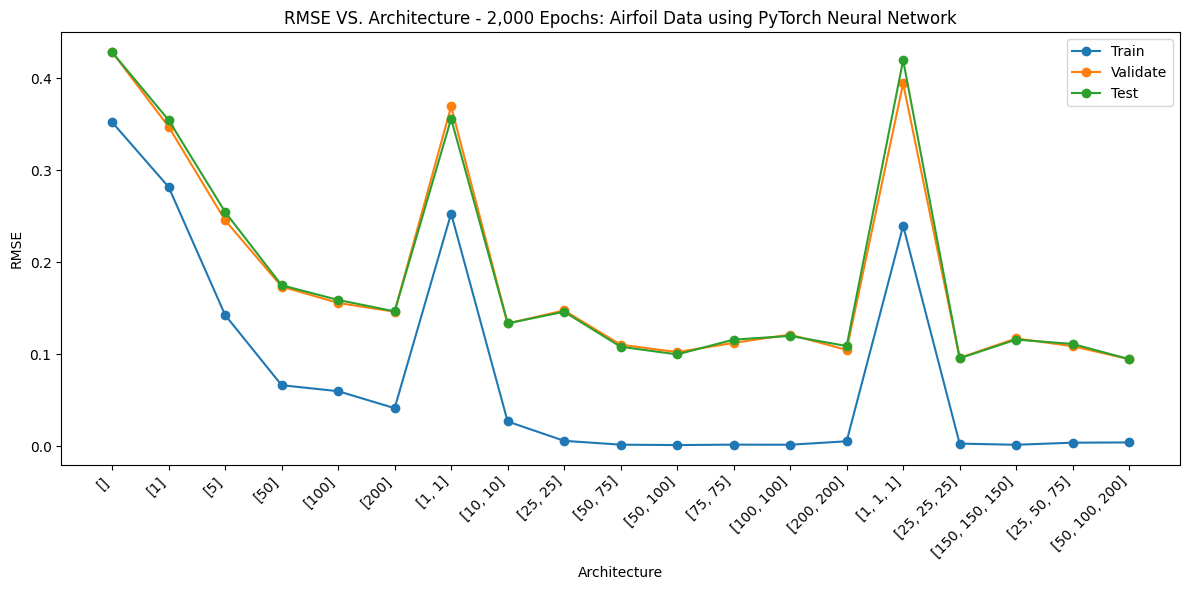

In [18]:
plot_results(results)

In [19]:
print(f'GPU took {gpu_elapsed:.2f} hours versus CPU took {cpu_elapsed:.2f} hours')

GPU took 0.25 hours versus CPU took 0.19 hours


### GPU Observations for Airfoil Dataset
When utilizing my GPU for training the model, it took longer to run when compared to utilizing my CPU. This is likely due to the size of the dataset being on the smaller side. Due to having to transfer the train, validation, and test sets, along with the model, to the GPU from the CPU and back again for each fold, there is more overhead. This overheard outweighs the performance advantages we would normally see with a larger dataset.

When using the GPU, we also see a lower value of max RMSE within the plot of architectures. While using CPU, the max RMSE is roughly 1.6 for the architectures tested, where the max RMSE for the GPU is roughly 0.4. This is likely due to the increase of computational power and efficiency gained from switching to the GPU while using a library made for GPU optimization, such as Pytorch. 

Additionally, the variance of RMSE between the train set when compared to the test and validations sets consistently sits around 0.1 when using the GPU for all architectures. The variance of RMSE between the train set, compared to the test and validations sets when using the CPU, is consistently 0.02 to 0.03. This may be a sign of lightly overfitting the data. So, some hyperparameter values, like learning rate and/or number of epochs, can probably be lowered for training the model with GPU utilization.

## New Data Experiment - Communities & Crime Dataset (C&C)
<u>**Dataset Citation:**</u> Redmond,Michael. (2009). Communities and Crime. UCI Machine Learning Repository. https://doi.org/10.24432/C53W3X.

In [20]:
from ucimlrepo import fetch_ucirepo 
    
communities_and_crime = fetch_ucirepo(id=183) 
X = communities_and_crime.data.features
X = X.apply(pandas.to_numeric, errors='coerce')
X = np.array((X.transpose().dropna()).transpose(), dtype = np.float64)
T = np.array(communities_and_crime.data.targets, dtype = np.float64)

In [21]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [50], [100], [200], [1, 1],
                                      [10, 10], [25, 25], [50, 75], [50, 100], [75, 75], 
                                      [100, 100], [200, 200], [1, 1, 1], [25, 25, 25], 
                                      [150, 150, 150], [25, 50, 75], [50, 100, 200]],
                                      2000, 0.001, 'tanh')

cpu_elapsed = (time.time() - start) / 60/ 60
print(f'Took {cpu_elapsed:.2f} hours')
results

Epoch 200: RMSE 0.139
Epoch 400: RMSE 0.133
Epoch 600: RMSE 0.132
Epoch 800: RMSE 0.131
Epoch 1000: RMSE 0.131
Epoch 1200: RMSE 0.130
Epoch 1400: RMSE 0.130
Epoch 1600: RMSE 0.130
Epoch 1800: RMSE 0.130
Epoch 2000: RMSE 0.130
Epoch 200: RMSE 0.129
Epoch 400: RMSE 0.125
Epoch 600: RMSE 0.123
Epoch 800: RMSE 0.122
Epoch 1000: RMSE 0.122
Epoch 1200: RMSE 0.122
Epoch 1400: RMSE 0.121
Epoch 1600: RMSE 0.121
Epoch 1800: RMSE 0.121
Epoch 2000: RMSE 0.121
Epoch 200: RMSE 0.150
Epoch 400: RMSE 0.142
Epoch 600: RMSE 0.138
Epoch 800: RMSE 0.137
Epoch 1000: RMSE 0.135
Epoch 1200: RMSE 0.134
Epoch 1400: RMSE 0.134
Epoch 1600: RMSE 0.133
Epoch 1800: RMSE 0.133
Epoch 2000: RMSE 0.133
Epoch 200: RMSE 0.136
Epoch 400: RMSE 0.131
Epoch 600: RMSE 0.130
Epoch 800: RMSE 0.129
Epoch 1000: RMSE 0.128
Epoch 1200: RMSE 0.128
Epoch 1400: RMSE 0.128
Epoch 1600: RMSE 0.128
Epoch 1800: RMSE 0.127
Epoch 2000: RMSE 0.127
Epoch 200: RMSE 0.140
Epoch 400: RMSE 0.136
Epoch 600: RMSE 0.133
Epoch 800: RMSE 0.132
Epoch 10

,Arch,RMSE Train,RMSE Val,RMSE Test
0,[],0.126670,0.137544,0.137374
1,[1],0.127050,0.140824,0.141475
2,[5],0.091388,0.163965,0.165393
3,[50],0.000848,0.188269,0.183778
4,[100],0.000817,0.172441,0.170315
5,[200],0.000564,0.166107,0.165418
6,"[1, 1]",0.126113,0.143237,0.143612
7,"[10, 10]",0.033798,0.205962,0.204690
8,"[25, 25]",0.006876,0.209857,0.207657
9,"[50, 75]",0.002208,0.199010,0.196159


In [22]:
def plot_results2(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.figure(figsize=(12, 6))
    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.xlabel('Architecture')
    plt.ylabel('RMSE')
    plt.title("RMSE VS. Architecture - 2,000 Epochs: Communities & Crime dataset using PyTorch Neural Network")
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

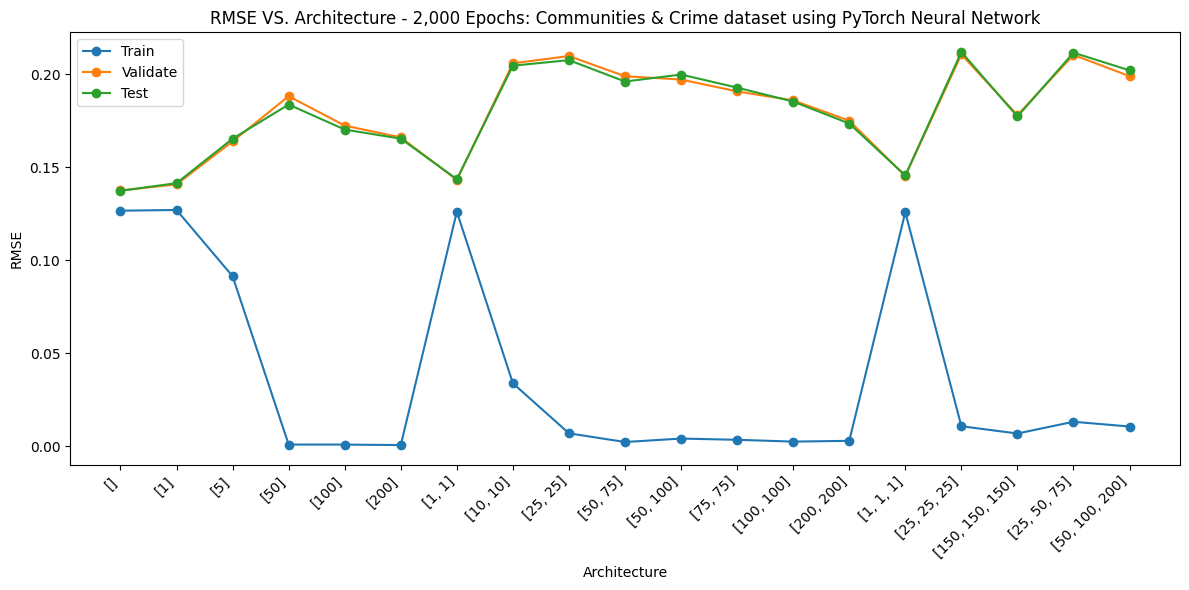

In [23]:
plot_results2(results)

In [24]:
gpu = True

start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [50], [100], [200], [1, 1],
                                      [10, 10], [25, 25], [50, 75], [50, 100], [75, 75], 
                                      [100, 100], [200, 200], [1, 1, 1], [25, 25, 25], 
                                      [150, 150, 150], [25, 50, 75], [50, 100, 200]],
                                      2000, 0.001, 'tanh', gpu)

gpu_elapsed = (time.time() - start) / 60/ 60
print(f'Took {gpu_elapsed:.2f} hours')
if gpu:
    print('   with GPU')
results

Moving data and model to GPU
Epoch 200: RMSE 0.133
Epoch 400: RMSE 0.130
Epoch 600: RMSE 0.128
Epoch 800: RMSE 0.128
Epoch 1000: RMSE 0.128
Epoch 1200: RMSE 0.127
Epoch 1400: RMSE 0.127
Epoch 1600: RMSE 0.127
Epoch 1800: RMSE 0.127
Epoch 2000: RMSE 0.127
Moving data and model to GPU
Epoch 200: RMSE 0.134
Epoch 400: RMSE 0.132
Epoch 600: RMSE 0.130
Epoch 800: RMSE 0.130
Epoch 1000: RMSE 0.129
Epoch 1200: RMSE 0.129
Epoch 1400: RMSE 0.129
Epoch 1600: RMSE 0.129
Epoch 1800: RMSE 0.129
Epoch 2000: RMSE 0.129
Moving data and model to GPU
Epoch 200: RMSE 0.139
Epoch 400: RMSE 0.135
Epoch 600: RMSE 0.133
Epoch 800: RMSE 0.132
Epoch 1000: RMSE 0.131
Epoch 1200: RMSE 0.130
Epoch 1400: RMSE 0.130
Epoch 1600: RMSE 0.130
Epoch 1800: RMSE 0.129
Epoch 2000: RMSE 0.129
Moving data and model to GPU
Epoch 200: RMSE 0.140
Epoch 400: RMSE 0.135
Epoch 600: RMSE 0.133
Epoch 800: RMSE 0.132
Epoch 1000: RMSE 0.131
Epoch 1200: RMSE 0.131
Epoch 1400: RMSE 0.131
Epoch 1600: RMSE 0.130
Epoch 1800: RMSE 0.130
Epo

,Arch,RMSE Train,RMSE Val,RMSE Test
0,[],0.126719,0.137620,0.137687
1,[1],0.126588,0.140425,0.139881
2,[5],0.091468,0.164053,0.162576
3,[50],0.000771,0.184474,0.183095
4,[100],0.000862,0.174987,0.172215
5,[200],0.001964,0.164046,0.164851
6,"[1, 1]",0.126944,0.145087,0.145072
7,"[10, 10]",0.034124,0.208076,0.201206
8,"[25, 25]",0.006502,0.207326,0.209241
9,"[50, 75]",0.003010,0.198176,0.200202


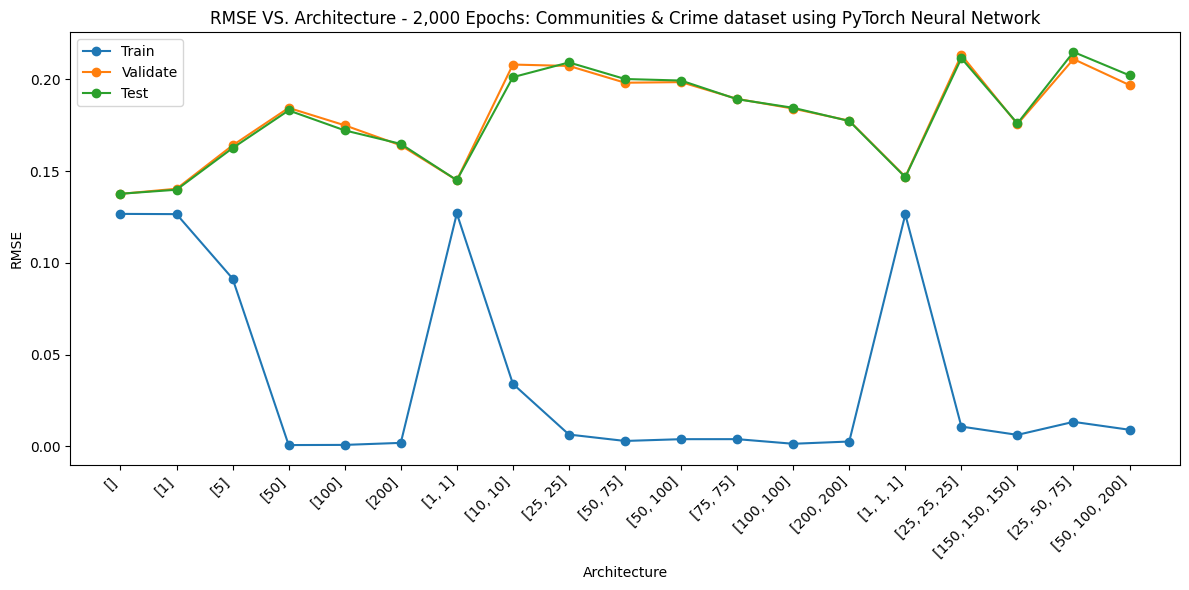

In [25]:
plot_results2(results)

In [26]:
print(f'GPU took {gpu_elapsed:.2f} hours versus CPU took {cpu_elapsed:.2f} hours')

GPU took 0.40 hours versus CPU took 0.31 hours


### GPU & Data Observations for the Communities & Crime Dataset
1. When comparing GPU and CPU times, we can see a slight improvement in performance time when utilizing the system's GPU. The C&C data set has roughly 400 more samples, along with roughly 100 more features, than the Airfoil data set. This increase of data is enough to see an improvement in the run-time performance of the model while utilizing the GPU. The GPU now performs better than the CPU since the time it takes for the model to perform computations with the dataset now outweighs the overhead created from the CPU and GPU transfers.
   
2. When observing the RMSE VS. Architecture plot, we can immediately see that the model does not perform as well with the C&C dataset as it did with the Airfoil dataset.
 - In fact, the model seems to be performing in the opposite way as it did with the Airfoil dataset. The best performance we see is when we have no hidden layers, or hidden layers with only one hidden unit. This shows me that the C&C dataset, though larger than the Airfoil Dataset, is not nearly as complex in features and feature correlations; and is causing the model to overfit the data.
 - We will likely see improvements by drastically lowering the number of epochs and/or slightly lowering the learning rate. From that point, we can run more trials to determine the best architectures for evaluating the data.
